### 数据预处理

In [3]:
import csv
import pandas as pd
import numpy as np
import json

In [4]:
# data = pd.read_csv('data_new.csv')
data = pd.read_csv('data_new_category.csv')

In [5]:
target = [["有回应","无回应"], 
        ['积极','中性','消极'], 
        ["专注（任务中）","走神（任务外）"], 
        ["主导", "支持", "旁观", "冲突", "玩乐", "闲聊", "一人独立尝试一人摸鱼", "各自神游"]]

In [6]:
data.head()

,high face 0,high face 1,high face 2,high face 3,high face 4,high face 5,high face 6,high face 7,high face 8,high face 9,...,low pose 210,low pose 211,low pose 212,low pose 213,low pose 214,low pose 215,y1,y2,y3,y4
0,0.359752,0.424275,-0.681706,0.433839,0.004776,0.001909,0.004776,0.001909,97.547158,48.476906,...,2.834029,1.354602,7.016298,13.097574,37.208326,12.016522,2,1,0,6
1,0.374953,0.477638,-0.666732,0.429372,0.010201,0.002640,0.010201,0.002640,94.752225,45.264284,...,2.437439,1.380893,8.850943,1.986816,14.843469,2.682850,2,1,0,6
2,0.374791,0.433773,-0.650851,0.302914,0.027013,0.007587,0.027013,0.007587,103.646422,66.342239,...,264.340206,138.834556,277.803936,40.606839,39.674292,7.152803,0,1,0,4
3,0.425997,0.407457,-0.651442,0.335262,0.018433,0.004401,0.018433,0.004401,107.650662,116.364404,...,1.480924,5.826735,0.277468,0.268455,3.716497,1.082155,2,1,0,4
4,0.283344,0.433831,-0.662919,0.331787,0.020136,0.011439,0.020136,0.011439,97.096686,181.962040,...,2745.552274,351.139817,2397.996836,735.777116,293.425847,120.226725,0,1,0,5


In [7]:
X = data.drop(['y1','y2','y3','y4'],axis=1)
y1 = data['y1']
y2 = data['y2']
y3 = data['y3']
y4 = data['y4']
y = data[['y1','y2','y3','y4']]

将 y1 '中'类合并

In [8]:
y1_replace_target = ["强","弱","没有回应（忽视）"]

# 中合并成强
y1_replace0 = y1.replace(1,0)
# 整体label 前移一位
y1_replace0 = y1_replace0.replace(2,1) # 修正缺失的 1
y1_replace0 = y1_replace0.replace(3,2) # 修正缺失的 2


# 中合并为弱
y1_replace1 = y1.replace(2,1)
# 整体label 前移一位
y1_replace1 = y1_replace1.replace(3,2) # 修正缺失的 2

将 y4 根据y2类别分开为两份

In [9]:
# "玩乐", "闲聊", "一人独立尝试一人摸鱼", "各自神游"
y4_1 = y4[y3==1]
y4_1_target = target[3][:4]
print(f"y4_1:{y4_1.min()} - {y4_1.max()}")
print(y4_1_target)
X_1 = X[y3==1]



# "主导", "支持", "旁观", "冲突"
y4_2 = y4[y3==0] 
y4_2_target = target[3][4:]
print(f"y4_2:{y4_2.min()} - {y4_2.max()}")
print(y4_2_target)
X_2 = X[y3==0]


y4_1:0 - 3
['玩乐', '闲聊', '一人独立尝试一人摸鱼', '各自神游']
y4_2:0 - 7
['主导', '支持', '旁观', '冲突']


存在错误标记

In [10]:
print(y4_2[y4_2 == 0].index)
print(y4_2[y4_2 == 1].index)
print(y4_2[y4_2 == 2].index)
print(y4_2[y4_2 == 3].index)

Index([121], dtype='int64')
Index([], dtype='int64')
Index([138, 139, 1949], dtype='int64')
Index([], dtype='int64')


In [11]:
wrong_idx = y4_2[y4_2 == 0].index
wrong_idx = wrong_idx.append(y4_2[y4_2 == 2].index)

In [12]:
# 删除
y4_2 = y4_2.drop(wrong_idx)
X_2 = X_2.drop(wrong_idx)
print(f"y4_2:{y4_2.min()} - {y4_2.max()}")

y4_2:4 - 7


In [13]:
X_1 = np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis=0, arr=X_1)
X_2 = np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis=0, arr=X_2)

In [14]:
# 调整 label 符号
y4_2 = y4_2 - 4
print(f"y4_2:{y4_2.min()} - {y4_2.max()}")

y4_2:0 - 3


检查 nan

In [15]:
idx = np.where(np.isnan(X).any(axis=1)==True)[0]
idx

array([], dtype=int64)

In [16]:
if len(idx) != 0:
    print(f"drop {len(idx)} rows with nan value")
    for i in idx:
        X = np.delete(X, i, axis=0)
        y1 = np.delete(y1, i, axis=0)
        y2 = np.delete(y2, i, axis=0)
        y3 = np.delete(y3, i, axis=0)
        y4 = np.delete(y4, i, axis=0)
        y = np.delete(y, i, axis=0)
else:
    X = np.array(X)
    y1 = np.array(y1)
    y2 = np.array(y2)
    y3 = np.array(y3)
    y4 = np.array(y4)
    y = np.array(y)

In [17]:
X_norm = np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis=0, arr=X)


In [18]:
# check nan in X_norm
np.where(np.isnan(X_norm).any(axis=1)==True)

(array([], dtype=int64),)

In [19]:
print(f"Read in videos y:{len(y1)}")

Read in videos y:3516


维度

In [20]:
print(f"X:{len(X[0])}")

X:373


## Train 
注意下面的重复，每次只能跑一个情况

In [21]:
from sklearn.model_selection import train_test_split
# frame split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)
print(f"Video num: X_train:{len(X_train)}, X_test:{len(X_test)}, y_train:{len(y_train)}, y_test:{len(y_test)}")

y1_train, y1_test = y_train[:,0], y_test[:,0]
y2_train, y2_test = y_train[:,1], y_test[:,1]
y3_train, y3_test = y_train[:,2], y_test[:,2]
y4_train, y4_test = y_train[:,3], y_test[:,3]

Video num: X_train:2812, X_test:704, y_train:2812, y_test:704


合并y1

In [22]:
#
X_train_replace0, X_test_replace0, y_train_replace0, y_test_replace0 = train_test_split(X_norm, y1_replace0, test_size=0.2, random_state=42)
X_train_replace1, X_test_replace1, y_train_replace1, y_test_replace1 = train_test_split(X_norm, y1_replace1, test_size=0.2, random_state=42)

分开y4

In [23]:
#
X_train_41, X_test_41, y_train_41, y_test_41 = train_test_split(X_1, y4_1, test_size=0.2, random_state=42)
X_train_42, X_test_42, y_train_42, y_test_42 = train_test_split(X_2, y4_2, test_size=0.2, random_state=42)

查看数据分布

强:850, 中:502, 弱:1466, 没有回应（忽视）:698, 


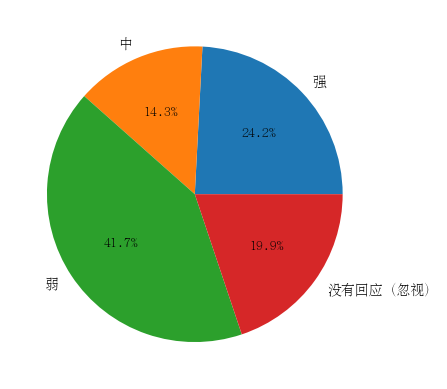

中性:1987, 积极:1050, 消极:479, 


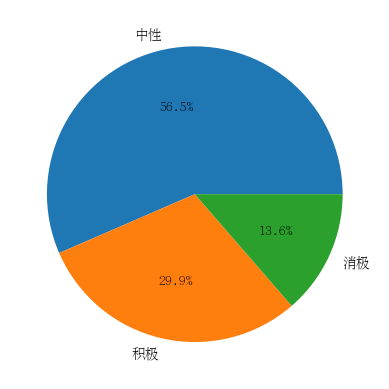

专注（任务中）:3102, 走神（任务外）:414, 


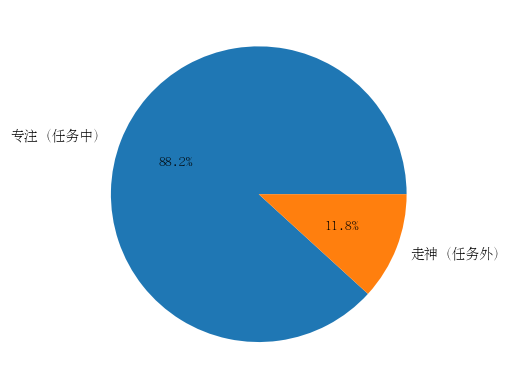

玩乐:13, 闲聊:36, 一人独立尝试一人摸鱼:350, 各自神游:19, 主导:993, 支持:1000, 旁观:1084, 冲突:21, 


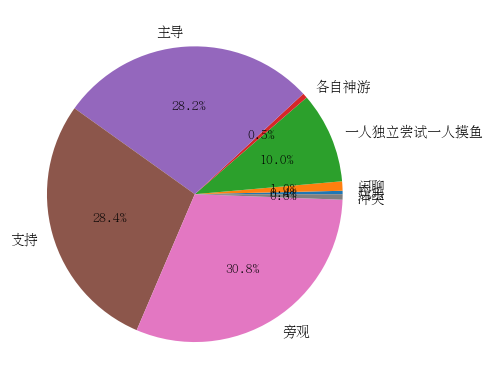

In [24]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  # 步骤一

plt.rcParams["font.sans-serif"]=["AR PL UMing CN"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

def num_of_cls(y, target): 
    N = []
    for i in range(len(target)):
        print(target[i] + f":{len(y[y==i])}", end=", ")
        N.append(len(y[y==i]))
    print()
    return N

for i in range(4):
    N = num_of_cls(y[:,i],target[i])
    # proportions = [ p/len(y) for p in N]
    plt.pie(N,labels=target[i],autopct='%1.1f%%')
    plt.show()


强:1352, 弱:1466, 没有回应（忽视）:698, 


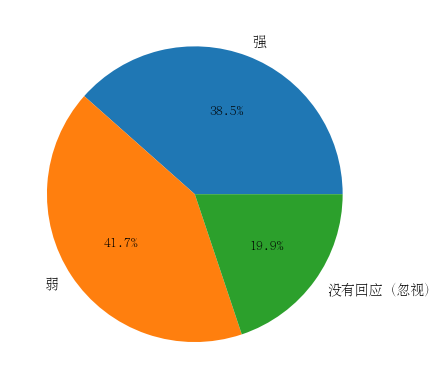

强:850, 弱:1968, 没有回应（忽视）:698, 


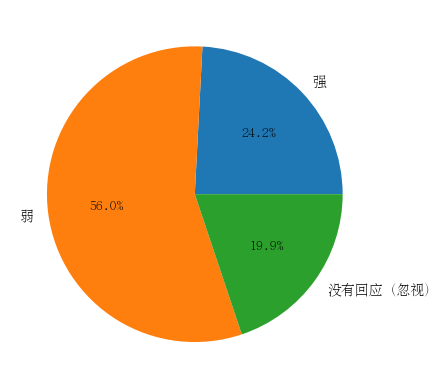

玩乐:12, 闲聊:36, 一人独立尝试一人摸鱼:347, 各自神游:19, 


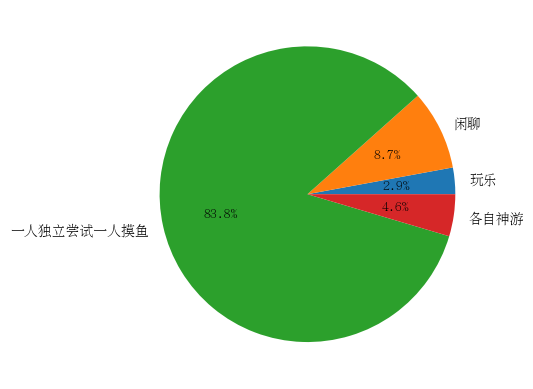

主导:993, 支持:1000, 旁观:1084, 冲突:21, 


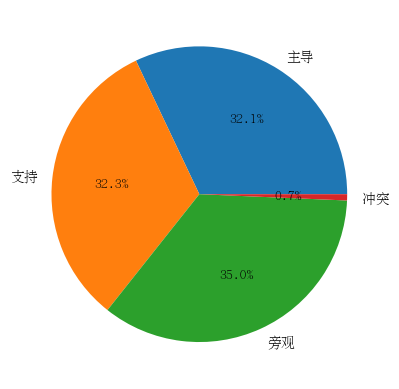

In [25]:
# 换
N = num_of_cls(y1_replace0,y1_replace_target)
plt.pie(N,labels=y1_replace_target,autopct='%1.1f%%')
plt.show()

N = num_of_cls(y1_replace1,y1_replace_target)
plt.pie(N,labels=y1_replace_target,autopct='%1.1f%%')
plt.show()

# y4-1
N = num_of_cls(y4_1,y4_1_target)
plt.pie(N,labels=y4_1_target,autopct='%1.1f%%')
plt.show()

N = num_of_cls(y4_2,y4_2_target)
plt.pie(N,labels=y4_2_target,autopct='%1.1f%%')
plt.show()

inversely proportional class weights

In [26]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights
class_weights = [class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(i), y=i) for i in [y1,y2,y3,y4]]


# Convert class weights to a dictionary for compatibility with some classifiers
class_weight_dict = [dict(enumerate(class_weights[i])) for i in range(4)]


In [27]:
# Calculate class weights
class_weights_y1_replace0 = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y1_replace0), y=y1_replace0) 
class_weights_y1_replace1 = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y1_replace1), y=y1_replace1) 

# Convert class weights to a dictionary for compatibility with some classifiers
class_weight_dict_y1_replace0 = dict(enumerate(class_weights_y1_replace0))
class_weight_dict_y1_replace1 = dict(enumerate(class_weights_y1_replace1))



In [28]:
# Calculate class weights
class_weights_y4_1 = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y4_1), y=y4_1) 
class_weights_y4_2 = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y4_2), y=y4_2) 

# Convert class weights to a dictionary for compatibility with some classifiers
class_weight_dict_y4_1 = dict(enumerate(class_weights_y4_1))
class_weight_dict_y4_2 = dict(enumerate(class_weights_y4_2))

over_sampling

In [32]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

# RandomOverSampler
X1_resampled, y1_resampled = RandomOverSampler(random_state=42).fit_resample(X_train, y1_train)
X2_resampled, y2_resampled = RandomOverSampler(random_state=42).fit_resample(X_train, y2_train)
X3_resampled, y3_resampled = RandomOverSampler(random_state=42).fit_resample(X_train, y3_train)
X4_resampled, y4_resampled = RandomOverSampler(random_state=42).fit_resample(X_train, y4_train)

# # SMOTE
# X1_resampled, y1_resampled = SMOTE().fit_resample(X_norm, y1)
# X2_resampled, y2_resampled = SMOTE().fit_resample(X_norm, y2)
# X3_resampled, y3_resampled = SMOTE().fit_resample(X_norm, y3)
# X4_resampled, y4_resampled = SMOTE().fit_resample(X_norm, y4)


Cross-validation  
- 5 folds

In [29]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV

def crossVal(rfc, X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = ['accuracy', 'f1_weighted', 'recall_weighted', 'precision_weighted']

    # 使用交叉验证器对模型进行评估
    scores = cross_validate(rfc, X, y, cv=kfold, scoring=scoring)

    # 输出交叉验证结果
    print('Accuracy:', scores['test_accuracy'].mean())
    print('F1 score:', scores['test_f1_weighted'].mean())
    print('Recall:', scores['test_recall_weighted'].mean())
    print('Precision:', scores['test_precision_weighted'].mean())

def GridSearch(estimator, param_grid, X_train, y_train, X_test, y_test, target, cv=5):
    # grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv)
    # grid_search = RandomizedSearchCV(estimator=estimator, param_grid=param_grid, cv=cv)
    # grid_search = HalvingGridSearchCV(estimator=estimator, param_distributions=param_grid, cv=cv)
    grid_search = HalvingRandomSearchCV(estimator=estimator,param_distributions=param_grid, cv=cv)


    grid_search.fit(X_train, y_train)

    # print(grid_search.best_params_, grid_search.best_score_)
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)
    
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    y_predict = best_model.predict(X_test)
    print("Test score:", test_score)
    print("Report:")
    report = classification_report(y_test, y_predict, target_names=target, zero_division=0)
    # print(classification_report(y_test, y_predict, target_names=target, zero_division=0))
    confMat = confusion_matrix(y_test, y_predict) # how to upload??
    return best_model, report, grid_search.best_params_

In [30]:
import csv
def parse_report( method, params, report, csv_dir):
    """
    method: [task, classifer, hyperparameters]
    """
    # Parse the classification report
    print(report)
    type(report)
    lines = report.split('\n')
    data = lines[-3:]
    values = [line.split() for line in data]

    # Extract the desired values
    precision = float(values[0][2])
    recall = float(values[0][3])
    f1_score = float(values[0][4])

    # Extract the desired values
    Wprecision = float(values[1][2])
    Wrecall = float(values[1][3])
    Wf1_score = float(values[1][4])

    # Print the extracted values
    print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1_score}, WPrecision: {Wprecision}, WRecall: {Wrecall}, WF1-score: {Wf1_score}")
    with open(csv_dir,'a',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(method)
        writer.writerow(params.keys())
        writer.writerow(params.values())
        writer.writerow([precision,recall,f1_score,Wprecision,Wrecall,Wf1_score])
        writer.writerow([])


### Random Forest

In [31]:

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# 使用随机森林预测一个frame
rfc = RandomForestClassifier(n_estimators=100, max_depth=10)
rfc.fit(X_train, y_train)
y_predict = rfc.predict(X_test)

for i in range(len(target)):
    print(f"----------------------Task {i}----------------------")
    print(classification_report(y_test[:,i], y_predict[:,i], target_names=target[i],zero_division=0))
    num_of_cls(y_predict[:,i],target[i])


----------------------Task 0----------------------
              precision    recall  f1-score   support

           强       0.46      0.22      0.30       170
           中       0.00      0.00      0.00       107
           弱       0.42      0.91      0.58       281
    没有回应（忽视）       0.72      0.09      0.16       146

    accuracy                           0.44       704
   macro avg       0.40      0.31      0.26       704
weighted avg       0.43      0.44      0.34       704

强:83, 中:0, 弱:603, 没有回应（忽视）:18, 
----------------------Task 1----------------------
              precision    recall  f1-score   support

          中性       0.57      0.99      0.73       381
          积极       0.81      0.17      0.29       224
          消极       0.00      0.00      0.00        99

    accuracy                           0.59       704
   macro avg       0.46      0.39      0.34       704
weighted avg       0.57      0.59      0.48       704

中性:656, 积极:48, 消极:0, 
----------------------Task 2

In [33]:
csv_dir = "result_new_full.csv"

#### task 1

In [50]:
# GridSearch

rfc = RandomForestClassifier()

# param_grid = {
#     'n_estimators': [10, 50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'class_weight':[class_weight_dict[0]] 
# }
# RandomForest,report,param = GridSearch(estimator=rfc, 
#                             param_grid=param_grid, 
#                             X_train=X_train, y_train=y1_train, 
#                             X_test=X_test, y_test=y1_test,
#                             target=target[0], cv=5)
                            
# parse_report(method=["task1","RandomForest"], params = param, report=report, csv_dir=csv_dir)


param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict_y1_replace0] 
}
RandomForest,report,param = GridSearch(estimator=rfc, 
                            param_grid=param_grid, 
                            X_train=X_train_replace0, y_train=y_train_replace0, 
                            X_test=X_test_replace0, y_test=y_test_replace0,
                            target=y1_replace_target, cv=5)
parse_report(method=["task1 replace 0","RandomForest"], params = param, report=report, csv_dir=csv_dir)

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict_y1_replace1] 
}
RandomForest,report,param = GridSearch(estimator=rfc, 
                            param_grid=param_grid, 
                            X_train=X_train_replace1, y_train=y_train_replace1, 
                            X_test=X_test_replace1, y_test=y_test_replace1,
                            target=y1_replace_target, cv=5)
parse_report(method=["task1 replace 1","RandomForest"], params = param, report=report, csv_dir=csv_dir)

Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30, 'class_weight': {0: 0.8668639053254438, 1: 0.7994542974079127, 2: 1.679083094555874}}
Best cross-validation score: 0.5241254083407577
Test score: 0.5596590909090909
Report:
              precision    recall  f1-score   support

           强       0.58      0.65      0.61       277
           弱       0.53      0.66      0.59       281
    没有回应（忽视）       0.67      0.19      0.30       146

    accuracy                           0.56       704
   macro avg       0.59      0.50      0.50       704
weighted avg       0.58      0.56      0.54       704

Precision: 0.59, Recall: 0.5, F1-score: 0.5, WPrecision: 0.58, WRecall: 0.56, WF1-score: 0.54
Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': {0: 1.3788235294117648, 1: 0.5955284552845529, 2: 1.679083094555874}}
Best cross-validation score: 0.5677926265326037
Te

#### Task 2

In [26]:
# GridSearch
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[1]] 
}
rfc = RandomForestClassifier()
RandomForest,report,param = GridSearch(estimator=rfc, param_grid=param_grid, 
                            X_train=X_train, y_train=y2_train, 
                            X_test=X_test, y_test=y2_test,
                            target=target[1], cv=5)

parse_report(method=["task2","RandomForest"], params = param, report=report, csv_dir=csv_dir)                            

Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'class_weight': {0: 0.5898339204831404, 1: 1.1161904761904762, 2: 2.4467640918580376}}
Best cross-validation score: 0.611454753722795
Test score: 0.6150568181818182
Report:
              precision    recall  f1-score   support

          中性       0.59      0.97      0.73       381
          积极       0.81      0.28      0.42       224
          消极       0.00      0.00      0.00        99

    accuracy                           0.62       704
   macro avg       0.47      0.42      0.38       704
weighted avg       0.58      0.62      0.53       704

Precision: 0.47, Recall: 0.42, F1-score: 0.38, WPrecision: 0.58, WRecall: 0.62, WF1-score: 0.53


#### Task 3

In [27]:
# GridSearch
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[2]] 
}
rfc = RandomForestClassifier()
RandomForest,report,param = GridSearch(estimator=rfc, param_grid=param_grid, 
                            X_train=X_train, y_train=y3_train, 
                            X_test=X_test, y_test=y3_test,
                            target=target[2], cv=5)
                            
parse_report(method=["task3","RandomForest"], params = param, report=report, csv_dir=csv_dir)  

Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30, 'class_weight': {0: 0.5667311411992263, 1: 4.246376811594203}}
Best cross-validation score: 0.8843595917899323
Test score: 0.8778409090909091
Report:
              precision    recall  f1-score   support

     专注（任务中）       0.88      1.00      0.93       617
     走神（任务外）       1.00      0.01      0.02        87

    accuracy                           0.88       704
   macro avg       0.94      0.51      0.48       704
weighted avg       0.89      0.88      0.82       704

Precision: 0.94, Recall: 0.51, F1-score: 0.48, WPrecision: 0.89, WRecall: 0.88, WF1-score: 0.82


#### Task 4

In [34]:
# GridSearch
# param_grid = {
#     'n_estimators': [10, 50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'class_weight':[class_weight_dict[3]] 
# }
# rfc = RandomForestClassifier()
# RandomForest,report,param = GridSearch(estimator=rfc, param_grid=param_grid, 
#                             X_train=X_train, y_train=y4_train, 
#                             X_test=X_test, y_test=y4_test,
#                             target=target[3], cv=5)
# parse_report(method=["task4","RandomForest"], params = param, report=report, csv_dir=csv_dir)  

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict_y4_1] 
}
rfc = RandomForestClassifier()
RandomForest,report,param = GridSearch(estimator=rfc, param_grid=param_grid, 
                            X_train=X_train_41, y_train=y_train_41, 
                            X_test=X_test_41, y_test=y_test_41,
                            target=y4_1_target, cv=5)
parse_report(method=["task4 - 1","RandomForest"], params = param, report=report, csv_dir=csv_dir) 

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict_y4_2] 
}
rfc = RandomForestClassifier()
RandomForest,report,param = GridSearch(estimator=rfc, param_grid=param_grid, 
                            X_train=X_train_42, y_train=y_train_42, 
                            X_test=X_test_42, y_test=y_test_42,
                            target=y4_2_target, cv=5)
parse_report(method=["task4 - 2","RandomForest"], params = param, report=report, csv_dir=csv_dir)  

Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'class_weight': {0: 8.625, 1: 2.875, 2: 0.29827089337175794, 3: 5.447368421052632}}
Best cross-validation score: 0.8369565217391305
Test score: 0.8192771084337349
Report:
              precision    recall  f1-score   support

          玩乐       0.00      0.00      0.00         2
          闲聊       1.00      0.12      0.22         8
  一人独立尝试一人摸鱼       0.82      1.00      0.90        67
        各自神游       0.00      0.00      0.00         6

    accuracy                           0.82        83
   macro avg       0.45      0.28      0.28        83
weighted avg       0.76      0.82      0.75        83

Precision: 0.45, Recall: 0.28, F1-score: 0.28, WPrecision: 0.76, WRecall: 0.82, WF1-score: 0.75
Best hyperparameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 30, 'class_weight': {0: 0.7799597180261832, 1: 0.7745, 2: 0.7144833948339483, 3: 36

### DT

In [36]:
from sklearn.tree import DecisionTreeClassifier
# 建立决策树分类器
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
for i in range(len(target)):
    print(f"----------------------Task {i}----------------------")
    print(classification_report(y_test[:,i], y_predict[:,i], target_names=target[i],zero_division=0))
    num_of_cls(y_predict[:,i],target[i])

----------------------Task 0----------------------
              precision    recall  f1-score   support

           强       0.30      0.28      0.29       170
           中       0.19      0.21      0.20       107
           弱       0.43      0.41      0.42       281
    没有回应（忽视）       0.27      0.29      0.28       146

    accuracy                           0.33       704
   macro avg       0.30      0.30      0.30       704
weighted avg       0.33      0.33      0.33       704

强:160, 中:119, 弱:267, 没有回应（忽视）:158, 
----------------------Task 1----------------------
              precision    recall  f1-score   support

          中性       0.58      0.61      0.59       381
          积极       0.45      0.42      0.43       224
          消极       0.14      0.13      0.14        99

    accuracy                           0.48       704
   macro avg       0.39      0.39      0.39       704
weighted avg       0.48      0.48      0.48       704

中性:406, 积极:205, 消极:93, 
----------------------

#### task 1

In [51]:
# GridSearch
clf = DecisionTreeClassifier()

# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'class_weight':[class_weight_dict[0]] 
# }
# DT,report,param = GridSearch(estimator=clf, 
#                 param_grid=param_grid, 
#                 X_train=X_train, y_train=y1_train, 
#                 X_test=X_test, y_test=y1_test,
#                 target=target[0], cv=5)
# parse_report(method=["task1","DT"], params = param, report=report, csv_dir=csv_dir)  

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
   'class_weight':[class_weight_dict_y1_replace0] 
}
DT,report,param = GridSearch(estimator=clf, 
                            param_grid=param_grid, 
                            X_train=X_train_replace0, y_train=y_train_replace0, 
                            X_test=X_test_replace0, y_test=y_test_replace0,
                            target=y1_replace_target, cv=5)
parse_report(method=["task1 replace 0","DT"], params = param, report=report, csv_dir=csv_dir)


param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
   'class_weight':[class_weight_dict_y1_replace1] 
}
 
DT,report,param = GridSearch(estimator=clf, 
                            param_grid=param_grid, 
                            X_train=X_train_replace1, y_train=y_train_replace1, 
                            X_test=X_test_replace1, y_test=y_test_replace1,
                            target=y1_replace_target, cv=5)
parse_report(method=["task1 replace 1","DT"], params = param, report=report, csv_dir=csv_dir)



Best hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 6, 'criterion': 'gini', 'class_weight': {0: 0.8668639053254438, 1: 0.7994542974079127, 2: 1.679083094555874}}
Best cross-validation score: 0.4631402995205973
Test score: 0.43323863636363635
Report:
              precision    recall  f1-score   support

           强       0.49      0.47      0.48       277
           弱       0.46      0.46      0.46       281
    没有回应（忽视）       0.29      0.32      0.30       146

    accuracy                           0.43       704
   macro avg       0.41      0.41      0.41       704
weighted avg       0.44      0.43      0.43       704

Precision: 0.41, Recall: 0.41, F1-score: 0.41, WPrecision: 0.44, WRecall: 0.43, WF1-score: 0.43
Best hyperparameters: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 50, 'criterion': 'entropy', 'class_weight': {0: 1.3788235294117648, 1: 0.5955284552845529, 2: 1.679083094555874}}
Best cross-validation score: 0.44912052946417

#### task 2

In [31]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[1]] 
}
clf = DecisionTreeClassifier()
DT,report,param = GridSearch(estimator=clf, 
                param_grid=param_grid, 
                X_train=X_train, y_train=y2_train, 
                X_test=X_test, y_test=y2_test,
                target=target[1], cv=5)

parse_report(method=["task2","DT"], params = param, report=report, csv_dir=csv_dir)  

Best hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 90, 'criterion': 'gini', 'class_weight': {0: 0.5898339204831404, 1: 1.1161904761904762, 2: 2.4467640918580376}}
Best cross-validation score: 0.4845539009800178
Test score: 0.4559659090909091
Report:
              precision    recall  f1-score   support

          中性       0.57      0.56      0.57       381
          积极       0.42      0.42      0.42       224
          消极       0.13      0.14      0.14        99

    accuracy                           0.46       704
   macro avg       0.37      0.37      0.37       704
weighted avg       0.46      0.46      0.46       704

Precision: 0.37, Recall: 0.37, F1-score: 0.37, WPrecision: 0.46, WRecall: 0.46, WF1-score: 0.46


#### task 3

In [32]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[2]] 
}
clf = DecisionTreeClassifier()
DT,report,param = GridSearch(estimator=clf, 
                param_grid=param_grid, 
                X_train=X_train, y_train=y3_train, 
                X_test=X_test, y_test=y3_test,
                target=target[2], cv=5)


parse_report(method=["task3","DT"], params = param, report=report, csv_dir=csv_dir)  

Best hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 15, 'criterion': 'entropy', 'class_weight': {0: 0.5667311411992263, 1: 4.246376811594203}}
Best cross-validation score: 0.8224916867331729
Test score: 0.8451704545454546
Report:
              precision    recall  f1-score   support

     专注（任务中）       0.91      0.91      0.91       617
     走神（任务外）       0.37      0.36      0.36        87

    accuracy                           0.85       704
   macro avg       0.64      0.64      0.64       704
weighted avg       0.84      0.85      0.84       704

Precision: 0.64, Recall: 0.64, F1-score: 0.64, WPrecision: 0.84, WRecall: 0.85, WF1-score: 0.84


#### task 4

In [37]:
clf = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict[3]] 
}
# DT,report,param = GridSearch(estimator=clf, 
#                 param_grid=param_grid, 
#                 X_train=X_train, y_train=y4_train, 
#                 X_test=X_test, y_test=y4_test,
#                 target=target[3], cv=5)


# parse_report(method=["task4","DT"], params = param, report=report, csv_dir=csv_dir)  

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict_y4_1] 
}
DT,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train_41, y_train=y_train_41, 
                            X_test=X_test_41, y_test=y_test_41,
                            target=y4_1_target, cv=5)
parse_report(method=["task4 - 1","DT"], params = param, report=report, csv_dir=csv_dir) 

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':[class_weight_dict_y4_2] 
}
DT,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train_42, y_train=y_train_42, 
                            X_test=X_test_42, y_test=y_test_42,
                            target=y4_2_target, cv=5)
parse_report(method=["task4 - 2","DT"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 40, 'criterion': 'gini', 'class_weight': {0: 8.625, 1: 2.875, 2: 0.29827089337175794, 3: 5.447368421052632}}
Best cross-validation score: 0.6731884057971015
Test score: 0.7349397590361446
Report:
              precision    recall  f1-score   support

          玩乐       0.00      0.00      0.00         2
          闲聊       0.33      0.12      0.18         8
  一人独立尝试一人摸鱼       0.83      0.88      0.86        67
        各自神游       0.14      0.17      0.15         6

    accuracy                           0.73        83
   macro avg       0.33      0.29      0.30        83
weighted avg       0.71      0.73      0.72        83

Precision: 0.33, Recall: 0.29, F1-score: 0.3, WPrecision: 0.71, WRecall: 0.73, WF1-score: 0.72
Best hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 8, 'criterion': 'gini', 'class_weight': {0: 0.7799597180261832, 1: 0.7745, 2: 0.7144833948339483, 3: 36.8809

### KNN

In [38]:
from sklearn.neighbors import KNeighborsClassifier

# 建立KNN分类器
clf = KNeighborsClassifier(n_neighbors=3)

#### task 1

In [52]:
# GridSearch
clf = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': list(range(1, 51))
}
# KNN,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
#                             X_train=X_train, y_train=y1_train, 
#                             X_test=X_test, y_test=y1_test,
#                             target=target[0], cv=5)
# parse_report(method=["task1","KNN"], params = param, report=report, csv_dir=csv_dir)  

KNN,report,param = GridSearch(estimator=clf, 
                            param_grid=param_grid, 
                            X_train=X_train_replace0, y_train=y_train_replace0, 
                            X_test=X_test_replace0, y_test=y_test_replace0,
                            target=y1_replace_target, cv=5)
parse_report(method=["task1 replace 0","KNN"], params = param, report=report, csv_dir=csv_dir)

KNN,report,param = GridSearch(estimator=clf, 
                            param_grid=param_grid, 
                            X_train=X_train_replace1, y_train=y_train_replace1, 
                            X_test=X_test_replace1, y_test=y_test_replace1,
                            target=y1_replace_target, cv=5)
parse_report(method=["task1 replace 1","KNN"], params = param, report=report, csv_dir=csv_dir)


/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 237, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "/home/ansonlo/

Best hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 15, 'leaf_size': 11}
Best cross-validation score: 0.47054685842772903
Test score: 0.4744318181818182
Report:
              precision    recall  f1-score   support

           强       0.50      0.53      0.51       277
           弱       0.45      0.62      0.52       281
    没有回应（忽视）       0.47      0.10      0.17       146

    accuracy                           0.47       704
   macro avg       0.48      0.42      0.40       704
weighted avg       0.48      0.47      0.45       704

Precision: 0.48, Recall: 0.42, F1-score: 0.4, WPrecision: 0.48, WRecall: 0.47, WF1-score: 0.45


/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 234, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/ho

Best hyperparameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 23, 'leaf_size': 39}
Best cross-validation score: 0.5673709218955496
Test score: 0.5411931818181818
Report:
              precision    recall  f1-score   support

           强       0.29      0.06      0.11       170
           弱       0.56      0.95      0.70       388
    没有回应（忽视）       0.33      0.01      0.01       146

    accuracy                           0.54       704
   macro avg       0.39      0.34      0.27       704
weighted avg       0.45      0.54      0.42       704

Precision: 0.39, Recall: 0.34, F1-score: 0.27, WPrecision: 0.45, WRecall: 0.54, WF1-score: 0.42


/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.23333333        nan 0.37333333 0.33333333 0.43333333 0.33333333
 0.43333333 0.23333333 0.26666667 0.41333333        nan 0.26666667
 0.41333333 0.22666667 0.26666667 0.23333333        nan 0.22
 0.3        0.22       0.26666667        nan 0.33333333 0.26666667
 0.23333333 0.36666667 0.41333333 0.34       0.23333333        nan
 0.38       0.26666667 0.23333333 0.26666667 0.36666667 0.41333333
        nan 0.33333333 0.3        0.43333333        nan 0.26666667
 0.27333333 0.34       0.38       0.34       0.33333333 0.34
 0.23333333 0.47333333        nan 0.34              nan        nan
 0.33333333 0.26666667 0.3        0.3        0.33333333        nan
 0.3        0.33333333 0.33333333 0.26       0.33333333 0.22
 0.38       0.23333333 0.26666667 0.41333333 0.37333333        nan
 0.23333333 0.26666667 0.38       0.38       0.3333

#### task 2

In [36]:
# GridSearch
param_grid = {
    'n_neighbors': list(range(1, 29)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': list(range(1, 51))
}
clf = KNeighborsClassifier()
KNN,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train, y_train=y2_train, 
                            X_test=X_test, y_test=y2_test,
                            target=target[1], cv=6)
parse_report(method=["task2","KNN"], params = param, report=report, csv_dir=csv_dir)                             

Best hyperparameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 16, 'leaf_size': 2}
Best cross-validation score: 0.5866178462796819
Test score: 0.5582386363636364
Report:
              precision    recall  f1-score   support

          中性       0.56      0.90      0.69       381
          积极       0.53      0.22      0.31       224
          消极       0.00      0.00      0.00        99

    accuracy                           0.56       704
   macro avg       0.37      0.37      0.34       704
weighted avg       0.47      0.56      0.48       704

Precision: 0.37, Recall: 0.37, F1-score: 0.34, WPrecision: 0.47, WRecall: 0.56, WF1-score: 0.48


#### task 3

In [37]:
param_grid = {
    'n_neighbors': list(range(1, 29)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': list(range(1, 51))
}
clf = KNeighborsClassifier()
KNN,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train, y_train=y3_train, 
                            X_test=X_test, y_test=y3_test,
                            target=target[2], cv=10)

parse_report(method=["task3","KNN"], params = param, report=report, csv_dir=csv_dir)  

Best hyperparameters: {'weights': 'uniform', 'p': 1, 'n_neighbors': 24, 'leaf_size': 2}
Best cross-validation score: 0.8927223952924888
Test score: 0.8764204545454546
Report:
              precision    recall  f1-score   support

     专注（任务中）       0.88      1.00      0.93       617
     走神（任务外）       0.00      0.00      0.00        87

    accuracy                           0.88       704
   macro avg       0.44      0.50      0.47       704
weighted avg       0.77      0.88      0.82       704

Precision: 0.44, Recall: 0.5, F1-score: 0.47, WPrecision: 0.77, WRecall: 0.88, WF1-score: 0.82


#### task 4

In [39]:
param_grid = {
    'n_neighbors': list(range(1, 29)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': list(range(1, 51))
}
clf = KNeighborsClassifier()
# KNN,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
#                             X_train=X_train, y_train=y4_train, 
#                             X_test=X_test, y_test=y4_test,
#                             target=target[3], cv=5)
# parse_report(method=["task4","KNN"], params = param, report=report, csv_dir=csv_dir)  


KNN,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train_41, y_train=y_train_41, 
                            X_test=X_test_41, y_test=y_test_41,
                            target=y4_1_target, cv=5)
parse_report(method=["task4 - 1","KNN"], params = param, report=report, csv_dir=csv_dir) 


KNN,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train_42, y_train=y_train_42, 
                            X_test=X_test_42, y_test=y_test_42,
                            target=y4_2_target, cv=5)
parse_report(method=["task4 - 2","KNN"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 25, 'leaf_size': 1}
Best cross-validation score: 0.8536231884057971
Test score: 0.8072289156626506
Report:
              precision    recall  f1-score   support

          玩乐       0.00      0.00      0.00         2
          闲聊       0.00      0.00      0.00         8
  一人独立尝试一人摸鱼       0.81      1.00      0.89        67
        各自神游       0.00      0.00      0.00         6

    accuracy                           0.81        83
   macro avg       0.20      0.25      0.22        83
weighted avg       0.65      0.81      0.72        83

Precision: 0.2, Recall: 0.25, F1-score: 0.22, WPrecision: 0.65, WRecall: 0.81, WF1-score: 0.72
Best hyperparameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 7, 'leaf_size': 47}
Best cross-validation score: 0.3747200689061154
Test score: 0.41451612903225804
Report:
              precision    recall  f1-score   support

          主导       0.40      0.53      0.45       205
          

### SVM
结果很差 看warning原因应该是有一些结果直接没有分类  
看看是否需要调参数或者直接去掉 

In [41]:
from sklearn.svm import SVC
clf = SVC()

#### task 1

In [53]:
# GridSearch
clf = SVC()


# param_grid = {
#     'C': [0.1, 1, 10, 100, 1000],
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
#     'class_weight':[class_weight_dict[0]]
# }
# svm,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
#                             X_train=X_train, y_train=y1_train, 
#                             X_test=X_test, y_test=y1_test,
#                             target=target[0], cv=5)

# parse_report(method=["task1","SVM"], params = param, report=report, csv_dir=csv_dir)  

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'class_weight':[class_weight_dict_y1_replace0] 
}
svm,report,param = GridSearch(estimator=clf, 
                            param_grid=param_grid, 
                            X_train=X_train_replace0, y_train=y_train_replace0, 
                            X_test=X_test_replace0, y_test=y_test_replace0,
                            target=y1_replace_target, cv=5)
parse_report(method=["task1 replace 0","svm"], params = param, report=report, csv_dir=csv_dir)

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'class_weight':[class_weight_dict_y1_replace1] 
}
svm,report,param = GridSearch(estimator=clf, 
                            param_grid=param_grid, 
                            X_train=X_train_replace1, y_train=y_train_replace1, 
                            X_test=X_test_replace1, y_test=y_test_replace1,
                            target=y1_replace_target, cv=5)
parse_report(method=["task1 replace 1","svm"], params = param, report=report, csv_dir=csv_dir)

Best hyperparameters: {'kernel': 'rbf', 'gamma': 100.0, 'class_weight': {0: 0.8668639053254438, 1: 0.7994542974079127, 2: 1.679083094555874}, 'C': 100}
Best cross-validation score: 0.480032243010479
Test score: 0.44886363636363635
Report:
              precision    recall  f1-score   support

           强       0.51      0.39      0.44       277
           弱       0.42      0.68      0.52       281
    没有回应（忽视）       0.43      0.10      0.17       146

    accuracy                           0.45       704
   macro avg       0.45      0.39      0.38       704
weighted avg       0.46      0.45      0.42       704

Precision: 0.45, Recall: 0.39, F1-score: 0.38, WPrecision: 0.46, WRecall: 0.45, WF1-score: 0.42
Best hyperparameters: {'kernel': 'rbf', 'gamma': 1000.0, 'class_weight': {0: 1.3788235294117648, 1: 0.5955284552845529, 2: 1.679083094555874}, 'C': 100}
Best cross-validation score: 0.5591294387170676
Test score: 0.5525568181818182
Report:
              precision    recall  f1-score 

#### task 2

In [41]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'class_weight':[class_weight_dict[1]]
}
clf = SVC()
svm,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train, y_train=y2_train, 
                            X_test=X_test, y_test=y2_test,
                            target=target[1], cv=5)

parse_report(method=["task2","SVM"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'kernel': 'linear', 'gamma': 10.0, 'class_weight': {0: 0.5898339204831404, 1: 1.1161904761904762, 2: 2.4467640918580376}, 'C': 100}
Best cross-validation score: 0.4870145517797294
Test score: 0.4758522727272727
Report:
              precision    recall  f1-score   support

          中性       0.62      0.50      0.55       381
          积极       0.49      0.46      0.48       224
          消极       0.22      0.42      0.29        99

    accuracy                           0.48       704
   macro avg       0.45      0.46      0.44       704
weighted avg       0.52      0.48      0.49       704

Precision: 0.45, Recall: 0.46, F1-score: 0.44, WPrecision: 0.52, WRecall: 0.48, WF1-score: 0.49


#### task 3

In [42]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'class_weight':[class_weight_dict[2]]
}
clf = SVC()
svm,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train, y_train=y3_train, 
                            X_test=X_test, y_test=y3_test,
                            target=target[2], cv=5)
parse_report(method=["task3","SVM"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'kernel': 'rbf', 'gamma': 100.0, 'class_weight': {0: 0.5667311411992263, 1: 4.246376811594203}, 'C': 10}
Best cross-validation score: 0.8825134732255474
Test score: 0.8764204545454546
Report:
              precision    recall  f1-score   support

     专注（任务中）       0.88      1.00      0.93       617
     走神（任务外）       0.50      0.02      0.04        87

    accuracy                           0.88       704
   macro avg       0.69      0.51      0.49       704
weighted avg       0.83      0.88      0.82       704

Precision: 0.69, Recall: 0.51, F1-score: 0.49, WPrecision: 0.83, WRecall: 0.88, WF1-score: 0.82


#### task 4

In [42]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'class_weight':[class_weight_dict[3]]
}
clf = SVC()
# svm,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
#                             X_train=X_train, y_train=y4_train, 
#                             X_test=X_test, y_test=y4_test,
#                             target=target[3], cv=5)
# parse_report(method=["task4","SVM"], params = param, report=report, csv_dir=csv_dir) 


param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'class_weight':[class_weight_dict_y4_1] 
}
svm,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train_41, y_train=y_train_41, 
                            X_test=X_test_41, y_test=y_test_41,
                            target=y4_1_target, cv=5)
parse_report(method=["task4 - 1","svm"], params = param, report=report, csv_dir=csv_dir) 

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'class_weight':[class_weight_dict_y4_2] 
}
svm,report,param = GridSearch(estimator=clf, param_grid=param_grid, 
                            X_train=X_train_42, y_train=y_train_42, 
                            X_test=X_test_42, y_test=y_test_42,
                            target=y4_2_target, cv=5)
parse_report(method=["task4 - 2","svm"], params = param, report=report, csv_dir=csv_dir) 



Best hyperparameters: {'kernel': 'poly', 'gamma': 100.0, 'class_weight': {0: 8.625, 1: 2.875, 2: 0.29827089337175794, 3: 5.447368421052632}, 'C': 100}
Best cross-validation score: 0.8271739130434783
Test score: 0.7228915662650602
Report:
              precision    recall  f1-score   support

          玩乐       0.00      0.00      0.00         2
          闲聊       0.17      0.12      0.14         8
  一人独立尝试一人摸鱼       0.83      0.88      0.86        67
        各自神游       0.00      0.00      0.00         6

    accuracy                           0.72        83
   macro avg       0.25      0.25      0.25        83
weighted avg       0.69      0.72      0.70        83

Precision: 0.25, Recall: 0.25, F1-score: 0.25, WPrecision: 0.69, WRecall: 0.72, WF1-score: 0.7
Best hyperparameters: {'kernel': 'linear', 'gamma': 0.001, 'class_weight': {0: 0.7799597180261832, 1: 0.7745, 2: 0.7144833948339483, 3: 36.88095238095238}, 'C': 10}
Best cross-validation score: 0.39605081826012056
Test score: 0.4338

### XGBoost

In [47]:
from xgboost import XGBClassifier
# 定义xgboost分类器模型
xgb = XGBClassifier(n_estimators=100, random_state=42)

#### task 1

In [48]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier(n_estimators=100, random_state=42)
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X_train, y_train=y1_train, 
                            X_test=X_test, y_test=y1_test,
                            target=target[0], cv=5)
parse_report(method=["task1","XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.9}
Best cross-validation score: 0.4521963824289406
Test score: 0.4758522727272727
Report:
              precision    recall  f1-score   support

           强       0.49      0.39      0.43       170
           中       0.50      0.02      0.04       107
           弱       0.47      0.80      0.59       281
    没有回应（忽视）       0.51      0.29      0.37       146

    accuracy                           0.48       704
   macro avg       0.49      0.37      0.36       704
weighted avg       0.49      0.48      0.42       704

Precision: 0.49, Recall: 0.37, F1-score: 0.36, WPrecision: 0.49, WRecall: 0.48, WF1-score: 0.42


upsampled!

In [49]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier(n_estimators=100, random_state=42)
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X1_resampled, y_train=y1_resampled, 
                            X_test=X_test, y_test=y1_test,
                            target=target[0], cv=5)
parse_report(method=["task1","upsample XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.9}
Best cross-validation score: 0.7453703703703703
Test score: 0.4943181818181818
Report:
              precision    recall  f1-score   support

           强       0.48      0.48      0.48       170
           中       0.21      0.04      0.06       107
           弱       0.50      0.76      0.61       281
    没有回应（忽视）       0.54      0.34      0.41       146

    accuracy                           0.49       704
   macro avg       0.43      0.40      0.39       704
weighted avg       0.46      0.49      0.45       704

Precision: 0.43, Recall: 0.4, F1-score: 0.39, WPrecision: 0.46, WRecall: 0.49, WF1-score: 0.45


#### task 2

In [50]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier(n_estimators=100, random_state=42)
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X_train, y_train=y2_train, 
                            X_test=X_test, y_test=y2_test,
                            target=target[1], cv=5)
parse_report(method=["task2","XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best cross-validation score: 0.6308251665181791
Test score: 0.6207386363636364
Report:
              precision    recall  f1-score   support

          中性       0.61      0.93      0.73       381
          积极       0.71      0.38      0.49       224
          消极       0.00      0.00      0.00        99

    accuracy                           0.62       704
   macro avg       0.44      0.43      0.41       704
weighted avg       0.56      0.62      0.55       704

Precision: 0.44, Recall: 0.43, F1-score: 0.41, WPrecision: 0.56, WRecall: 0.62, WF1-score: 0.55


Upsample

In [51]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier()
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X2_resampled, y_train=y2_resampled, 
                            X_test=X_test, y_test=y2_test,
                            target=target[1], cv=5)
parse_report(method=["task2","upsample XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.9, 'n_estimators': 1000, 'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.4, 'colsample_bytree': 0.9}
Best cross-validation score: 0.7611302023673158
Test score: 0.6377840909090909
Report:
              precision    recall  f1-score   support

          中性       0.64      0.86      0.73       381
          积极       0.68      0.47      0.56       224
          消极       0.47      0.15      0.23        99

    accuracy                           0.64       704
   macro avg       0.60      0.49      0.51       704
weighted avg       0.63      0.64      0.61       704

Precision: 0.6, Recall: 0.49, F1-score: 0.51, WPrecision: 0.63, WRecall: 0.64, WF1-score: 0.61


#### task 3

In [52]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier(n_estimators=100, random_state=42)
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X_train, y_train=y3_train, 
                            X_test=X_test, y_test=y3_test,
                            target=target[2], cv=5)
parse_report(method=["task3","XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best cross-validation score: 0.8917784657722738
Test score: 0.8963068181818182
Report:
              precision    recall  f1-score   support

     专注（任务中）       0.91      0.98      0.94       617
     走神（任务外）       0.69      0.29      0.41        87

    accuracy                           0.90       704
   macro avg       0.80      0.63      0.67       704
weighted avg       0.88      0.90      0.88       704

Precision: 0.8, Recall: 0.63, F1-score: 0.67, WPrecision: 0.88, WRecall: 0.9, WF1-score: 0.88


upsampled

In [53]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier()
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X3_resampled, y_train=y3_resampled, 
                            X_test=X_test, y_test=y3_test,
                            target=target[2], cv=5)
parse_report(method=["task3","upsample XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best cross-validation score: 0.9853909465020576
Test score: 0.8835227272727273
Report:
              precision    recall  f1-score   support

     专注（任务中）       0.92      0.95      0.93       617
     走神（任务外）       0.54      0.40      0.46        87

    accuracy                           0.88       704
   macro avg       0.73      0.68      0.70       704
weighted avg       0.87      0.88      0.88       704

Precision: 0.73, Recall: 0.68, F1-score: 0.7, WPrecision: 0.87, WRecall: 0.88, WF1-score: 0.88


#### task 4

In [54]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier()
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X_train, y_train=y4_train, 
                            X_test=X_test, y_test=y4_test,
                            target=target[3], cv=8)
parse_report(method=["task4","XGBoost"], params = param, report=report, csv_dir=csv_dir) 

/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
105 fits failed out of a total of 168.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/xgboost/sklearn.py", line 1440, in fit
    raise ValueError(


Best hyperparameters: {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best cross-validation score: 0.45810266122766125
Test score: 0.47301136363636365
Report:
              precision    recall  f1-score   support

          玩乐       0.00      0.00      0.00         4
          闲聊       0.00      0.00      0.00         4
  一人独立尝试一人摸鱼       0.61      0.43      0.51        76
        各自神游       0.00      0.00      0.00         4
          主导       0.46      0.63      0.53       194
          支持       0.45      0.40      0.42       200
          旁观       0.48      0.46      0.47       212
          冲突       0.00      0.00      0.00        10

    accuracy                           0.47       704
   macro avg       0.25      0.24      0.24       704
weighted avg       0.46      0.47      0.46       704

Precision: 0.25, Recall: 0.24, F1-score: 0.24, WPrecision: 0.46, WRecall: 0.47, WF1-score: 0.46


In [55]:
# GridSearch
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier()
xbgs,report,param = GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X4_resampled, y_train=y4_resampled, 
                            X_test=X_test, y_test=y4_test,
                            target=target[3], cv=5)
parse_report(method=["task4","upsample XGBoost"], params = param, report=report, csv_dir=csv_dir) 

Best hyperparameters: {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
Best cross-validation score: 0.82597442680776
Test score: 0.48011363636363635
Report:
              precision    recall  f1-score   support

          玩乐       0.00      0.00      0.00         4
          闲聊       1.00      0.25      0.40         4
  一人独立尝试一人摸鱼       0.54      0.50      0.52        76
        各自神游       0.00      0.00      0.00         4
          主导       0.50      0.59      0.54       194
          支持       0.46      0.45      0.45       200
          旁观       0.46      0.45      0.46       212
          冲突       0.00      0.00      0.00        10

    accuracy                           0.48       704
   macro avg       0.37      0.28      0.30       704
weighted avg       0.47      0.48      0.47       704

Precision: 0.37, Recall: 0.28, F1-score: 0.3, WPrecision: 0.47, WRecall: 0.48, WF1-score: 0.47


### LSTM  
not working so far

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb = XGBClassifier()
GridSearch(estimator=xgb, param_grid=param_grid, 
                            X_train=X_train, y_train=y4_train, 
                            X_test=X_test, y_test=y4_test,
                            target=target[3], cv=8)

/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
154 fits failed out of a total of 176.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
22 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/home/ansonlo/anaconda3/envs/torch/lib/python3.8/site-packages/xgboost/sklearn.py", line 1440, in fit
    raise ValueError(


In [77]:
from torch import nn
import torch

class LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(100, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 4) # 4 classes
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x) # 1 * 100
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out
        
class mil_regression(nn.Module):
    def __init__(self, input_size=786, hidden_size=100, num_layers=1, output_size=1):
        ''' use LSTM for MIL '''
        super(mil_regression, self).__init__()
        self.net = LSTM(input_size, hidden_size, num_layers)
        self.class_num = output_size

    def forward(self, inputs):
        # input shape: (frame_num, feature_size)
        

        self.seg_num, self.feature_num = inputs.shape #

        # outputs = torch.zeros((self.seg_num, self.class_num)).double.cuda() #  frame * 4（bool）

        outputs = self.net(inputs)
        # for i in range(self.seg_num):
        #     outputs[i,:] = self.net(inputs[i]) # 786

        # for idx, seg in enumerate(inputs):
        #     seg = Variable(seg).cuda()
        #     outputs[idx] = self.net(seg)

        # 视频特征 = frame取平均
        output = torch.mean(outputs, 1).cuda()
        return output

In [ ]:
import torch 

model = mil_regression().cuda()

epochs = 150
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    for i in range(len(X_train)): # 每次处理一个视频(对batch)

        x = torch.tensor(X_train[i]).float().cuda()
        y = torch.tensor(y_train[i]).float().cuda()
        

        if len(x.shape) ==1:
            continue

        optimizer.zero_grad()
        
        y_pred = model(x)

        single_loss = loss_function(y_pred, y)
        single_loss.backward()
        optimizer.step()
        
        # if (i+1) % 10 == 0:
        #     print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, len(X_train), single_loss.item()))

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [ ]:
with torch.no_grad():
    
    correct = 0
    total = 0
    for i in range(len(X_test)): # 每次处理一个视频(对batch)
        x = torch.tensor(X_test[i]).float().cuda()
        y = torch.tensor(y_test[i]).float().cuda()
        print(y)

        if len(x.shape) ==1:
            continue

        outputs = model(x)
        print(outputs)
        correct += (outputs == y)

### testing

In [10]:
import numpy as np

# 创建一个二维矩阵
x = np.array([[1, 2, 3], [4, 5, 6], [5, 8, 100],[5, 8, 100]])

# 计算梯度
dy = np.gradient(x)

# 输出结果
print(dy)


[array([[ 3. ,  3. ,  3. ],
       [ 2. ,  3. , 48.5],
       [ 0.5,  1.5, 47. ],
       [ 0. ,  0. ,  0. ]]), array([[ 1. ,  1. ,  1. ],
       [ 1. ,  1. ,  1. ],
       [ 3. , 47.5, 92. ],
       [ 3. , 47.5, 92. ]])]


In [9]:
import numpy as np

# 创建一个二维数组
x = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# 计算每一行相邻行之间的二阶导数
d2x = []
for i in range(1, x.shape[0]-1):
    dx1 = np.gradient(x[i-1, :])
    dx2 = np.gradient(x[i, :])
    dx3 = np.gradient(x[i+1, :])
    d2x.append(np.diff(dx2-dx1) / np.diff(dx3-dx2))

# 输出结果
print(d2x)


[array([nan, nan])]


/tmp/ipykernel_162420/1742590338.py:12: RuntimeWarning: invalid value encountered in divide
  d2x.append(np.diff(dx2-dx1) / np.diff(dx3-dx2))


In [11]:
import numpy as np

# 创建一个二维数组
x = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# 计算每一行数据对上一行数据的导数
dx = []
for i in range(1, x.shape[0]):
    diff = np.diff(x[i, :]) / np.diff(x[i-1, :])
    dx.append(diff)

# 输出结果
print(dx)


[array([1., 1.]), array([1., 1.])]


In [37]:
import pandas as pd

# 假设df是一个DataFrame对象，其中包含frame和feature两列
df = pd.DataFrame({'frame': [1, 3], 'feature': [1, 5]})

# 将df的索引设置为frame列，并增加需要插值的索引值
df = df.set_index('frame').reindex(range(df['frame'].min(), df['frame'].max()+1))

# 对df进行插值
df_interpolated = df.interpolate().reset_index()

# 输出插值结果
print(df_interpolated)


   frame  feature
0      1      1.0
1      2      3.0
2      3      5.0
